# **Chicago Crime Data Project**

## Author: **Jonathan Markey**

---

### **Description**

This project analyses the 2012 Chicago City Crime Data. The project utilises multiple classification models to determine if an arrest can be predicted for a crime based on the features of:
- Whether the crime was a domestic incident
- The primary type of the crime.
- The community area it took place in.
- The month, day, weekday, and hour the crime took place in.

Preprocessing and feature engineering has been conducted to amplify the dataset and develop the most effective models possible.

The classification models utilised in this project are:
- Naive Bayes
- Logistic Regression
- Random Forest
- High-Density Based Patial Clustering of Applications with Noise
- Multi-Layer Perceptron

Once Predictions have been made with these models an ensemble method is utilised using a single layer perceptron to get the final prediction.

---

## **Library Import and Database connection**

In [ ]:
# Data Libary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sqlite3
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from scipy.spatial.distance import cdist
import hdbscan
import random
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.graph_objects as go
import plotly.subplots as sp
from sqlalchemy import create_engine

In [2]:
# Connecting to the database and loading the sql magic extension
conn = sqlite3.connect("CrimeReport.db")
cur = conn.cursor()
%load_ext sql
%sql sqlite:///CrimeReport.db

cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
available_table=(cur.fetchall())
print(available_table)

[('CENSUS_DATA',), ('COMM_AREA_GIS',), ('CRIME_DATA',), ('HEALTH_DATA',), ('SCHOOLS_DATA',)]


---

### **Loading Data From Local Database**

In [3]:
%%sql
SELECT COUNT(*) FROM CRIME_DATA
WHERE PRIMARY_TYPE IS NULL OR ARREST IS NULL OR DOMESTIC IS NULL OR COMMUNITY_AREA IS NULL OR MONTH IS NULL OR DAY IS NULL OR WEEKDAY IS NULL OR HOUR IS NULL;

 * sqlite:///CrimeReport.db
Done.


COUNT(*)
26


In [4]:
%%sql
DROP VIEW IF EXISTS CRIME_DATA_SUB;

CREATE VIEW CRIME_DATA_SUB AS
SELECT 
    primary_type, 
    arrest, 
    domestic, 
    community_area,
    month, 
    day, 
    weekday, 
    hour    
FROM CRIME_DATA
WHERE
    primary_type IS NOT NULL AND 
    arrest IS NOT NULL AND 
    domestic IS NOT NULL AND 
    community_area IS NOT NULL AND 
    month IS NOT NULL AND 
    day IS NOT NULL AND 
    weekday IS NOT NULL AND 
    hour IS NOT NULL;

 * sqlite:///CrimeReport.db
Done.
Done.


[]

---

### **Exploratory Data Analysis of the Crime Data**

In [5]:
%%sql

SELECT PRIMARY_TYPE, COUNT(PRIMARY_TYPE) AS FREQUENCY FROM CRIME_DATA_SUB GROUP BY PRIMARY_TYPE ORDER BY FREQUENCY DESC;

 * sqlite:///CrimeReport.db
Done.


primary_type,FREQUENCY
THEFT,75457
BATTERY,59130
CRIMINAL DAMAGE,35854
NARCOTICS,35483
BURGLARY,22841
ASSAULT,19895
OTHER OFFENSE,17524
MOTOR VEHICLE THEFT,16490
DECEPTIVE PRACTICE,13774
ROBBERY,13483


Given the large dataset of over 200,000 observations we will consolodate the primary_type classes with < 200 into single type called other. Crime types less than 200 are unlikely to offer the models any enhanced level of interpretability but are likely to increase compute and processing times.

In [6]:
%%sql
DROP VIEW IF EXISTS CDS_UPDATED;

CREATE VIEW CDS_UPDATED AS
SELECT
    CASE
        WHEN PRIMARY_TYPE IN (
            SELECT PRIMARY_TYPE
            FROM CRIME_DATA_SUB
            GROUP BY PRIMARY_TYPE
            HAVING COUNT(PRIMARY_TYPE) < 200
        ) THEN 'OTHER'
        ELSE PRIMARY_TYPE
    END AS primary_type,
    ARREST,
    DOMESTIC,
    COMMUNITY_AREA,
    MONTH,
    DAY,
    WEEKDAY,
    HOUR
FROM CRIME_DATA_SUB;

SELECT PRIMARY_TYPE, COUNT(PRIMARY_TYPE) FROM CDS_UPDATED GROUP BY PRIMARY_TYPE ORDER BY COUNT(PRIMARY_TYPE) DESC;

 * sqlite:///CrimeReport.db
Done.
Done.
Done.


primary_type,COUNT(PRIMARY_TYPE)
THEFT,75457
BATTERY,59130
CRIMINAL DAMAGE,35854
NARCOTICS,35483
BURGLARY,22841
ASSAULT,19895
OTHER OFFENSE,17524
MOTOR VEHICLE THEFT,16490
DECEPTIVE PRACTICE,13774
ROBBERY,13483


In [7]:
%%sql
SELECT * FROM CDS_UPDATED LIMIT 3;

 * sqlite:///CrimeReport.db
Done.


primary_type,arrest,domestic,community_area,month,day,weekday,hour
BURGLARY,0,0,17.0,12,31,1,23
THEFT,0,0,41.0,12,31,1,23
BURGLARY,0,0,16.0,12,31,1,23


In [8]:
# Creating stacked barcharts for the primary_type of crime by year, month, weekday and hour
crime_data_ = %sql SELECT * FROM CDS_UPDATED;
crime_data_df = crime_data_.DataFrame()
crime_data_df.head()

 * sqlite:///CrimeReport.db
Done.


,primary_type,arrest,domestic,community_area,month,day,weekday,hour
0,BURGLARY,0,0,17.0,12,31,1,23
1,THEFT,0,0,41.0,12,31,1,23
2,BURGLARY,0,0,16.0,12,31,1,23
3,PUBLIC PEACE VIOLATION,1,0,8.0,12,31,1,23
4,THEFT,0,0,6.0,12,31,1,23


In [ ]:
# Function to pivot table for each feature for stacked bar charts
def create_pivot_df(variable):
    query = conn.execute(f'''SELECT {variable}, ARREST, COUNT(*) AS FREQUENCY FROM CDS_UPDATED GROUP BY {variable}, ARREST''')
    df = pd.DataFrame(query.fetchall(), columns=[variable, 'ARREST', 'FREQUENCY'])
    # Community_Area requires sorting to display the data in the correct order
    if variable == 'COMMUNITY_AREA':
        df[variable] = df[variable].astype(int)
        df = df.sort_values(by=variable)
    pivot_df = df.pivot(index=variable, columns='ARREST', values='FREQUENCY').fillna(0)
    return pivot_df

In [ ]:
colors = ['#636EFA', '#EF553B']  # blue for no arrest, red for arrest

# Temporal variables to plot
temporal_variables = ['MONTH', 'DAY', 'WEEKDAY', 'HOUR']
weekday_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Create subplot figure
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=[f'Crime Frequency by {var}' for var in temporal_variables])

# Loop through variables and add traces
for idx, var in enumerate(temporal_variables):
    pivot_df = create_pivot_df(var)
    x_labels = pivot_df.index.tolist()
    
    if var == 'WEEKDAY':
        x_labels = weekday_names  # Adjusting x-axis labels for weekdays
    
    row, col = divmod(idx, 2)
    row += 1  # Adjust for 1-based indexing in plotly
    col += 1
    
    for i, arrest_status in enumerate(pivot_df.columns):
        fig.add_trace(
            go.Bar(name=f'Arrest: {arrest_status}', x=x_labels, y=pivot_df[arrest_status], 
                   marker_color=colors[i]),
            row=row, col=col
        )

# Update layout for readability
fig.update_layout(
    title='Stacked Crime Frequency by Temporal Variables',
    barmode='stack',
    height=800,
    width=1000,
    showlegend=False
)

# Show plot
fig.show()


In [ ]:
# Plotting the other non-temporal variables in the dataset
other_variables = ['DOMESTIC', 'COMMUNITY_AREA', 'PRIMARY_TYPE']

# Create subplot figure
fig = sp.make_subplots(rows=3, cols=1, subplot_titles=[f'Crime Frequency by {var}' for var in other_variables])

# Loop through variables and add traces
for idx, var in enumerate(other_variables):
    pivot_df = create_pivot_df(var)
    x_labels = pivot_df.index.tolist()
    
    if var == 'COMMUNITY_AREA':
        x_labels = [str(label) for label in x_labels]  # Ensure all labels are visible
    
    row = idx + 1  # Adjust for 1-based indexing in plotly
    
    for i, arrest_status in enumerate(pivot_df.columns):
        fig.add_trace(
            go.Bar(name=f'Arrest: {arrest_status}', x=x_labels, y=pivot_df[arrest_status], 
                   marker_color=colors[i]),
            row=row, col=1
        )

# Update layout for readability
fig.update_layout(
    title='Stacked Crime Frequency by Other Variables',
    barmode='stack',
    height=900,
    width=1000,
    showlegend=False,
    xaxis=dict(type='category')  # Ensure categorical treatment of x-axis
)

# Show plot
fig.show()

---

### **Data Preprocessing**

In [17]:
crime_data_df.head()

,primary_type,arrest,domestic,community_area,month,day,weekday,hour
0,BURGLARY,0,0,17.0,12,31,1,23
1,THEFT,0,0,41.0,12,31,1,23
2,BURGLARY,0,0,16.0,12,31,1,23
3,PUBLIC PEACE VIOLATION,1,0,8.0,12,31,1,23
4,THEFT,0,0,6.0,12,31,1,23


In [18]:
# base data transformation
# Encode hour as sin and cos, one-hot encode the categorical variables and split the data into two dataframes for arrest and domestic.
crime_data_df['hour_sin'] = np.sin(2 * np.pi * crime_data_df['hour'] / 24)
crime_data_df['hour_cos'] = np.cos(2 * np.pi * crime_data_df['hour'] / 24)

# One-hot encode the categorical variables
crime_data_df = pd.get_dummies(crime_data_df, columns=['primary_type', 'weekday', 'month', 'community_area'], drop_first=True)
crime_data_df_arrest = crime_data_df

arrest_train, arrest_test = train_test_split(crime_data_df_arrest, test_size=0.2, random_state=42)
print("Unique values in 'arrest_train':")
print(arrest_train['arrest'].value_counts())
print("\nUnique values in 'arrest_test':")
print(arrest_test['arrest'].value_counts())

Unique values in 'arrest_train':
arrest
0    196537
1     72519
Name: count, dtype: int64

Unique values in 'arrest_test':
arrest
0    49110
1    18154
Name: count, dtype: int64


In [19]:
# Implementing bootstrap aggregation to create multiple balanced datasets for the arrest and domestic dataframes
# Bootstrap aggregation is used as the dataset is imbalanced in favor of arrest = 0. Upsampling can cause overfitting and downsampling can cause loss of information.
# Creating 10 balanced datasets for the arrest data ensures that loss of information is minimized and overfitting is avoided.

def bootstrap_aggregation(dataset, var):
    n_bootstraps = 10
    downsampled_datasets = []
    majority_class = dataset[dataset[var] == 0]
    minority_class = dataset[dataset[var] == 1]

    # creating 10 random seed values to be used in the resampling
    random.seed(0)
    random_values = [random.randint(0, 1000) for _ in range(n_bootstraps)] # [864, 394, 776, 911, 430, 41, 265, 988, 523, 497]

    for i in range(n_bootstraps):
        downsampled_majority = resample(majority_class, replace=False, n_samples=minority_class.shape[0], random_state=random_values[0])
        downsampled_data = pd.concat([downsampled_majority, minority_class])
        downsampled_datasets.append(downsampled_data)
        
    return downsampled_datasets

In [20]:
arrest_ba = bootstrap_aggregation(arrest_train, 'arrest')

In [21]:
# defining scaler and fitting to the full training dataset for use later in the models
scaler = StandardScaler()
scaler.fit(arrest_train[arrest_train.columns.drop('arrest')])

StandardScaler()

---

## **Classification Models**:

In [22]:
def eval_metrics(y_pred, y_test):
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision_recall = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(precision_recall[1], precision_recall[0])
    confusion_matrix_ = confusion_matrix(y_test, y_pred)
    classification_report_ = classification_report(y_test, y_pred)
    
    return f1, roc_auc, pr_auc, confusion_matrix_, classification_report_

### **Naive Bayes**

In [23]:
def nb_classifier(bootstrap_aggregation):
    models = []
    # For assessing the model performance on the training data
    f1_scores = []
    roc_auc_scores = []
    pr_auc_scores = []

    # Train models and evaluate on the training data
    for i, dataset in enumerate(bootstrap_aggregation):
        X_train = dataset[dataset.columns.drop('arrest')]
        X_train_scaled = scaler.transform(X_train)
        y_train = dataset['arrest']
        #print(f"Processing bootstrapped dataset {i+1}")
        
        # Gaussian Naive Bayes classifier
        model = GaussianNB()
        model.fit(X_train_scaled, y_train)
        models.append(model)
        
        # Predict probabilities and labels for the training set
        y_prob = model.predict_proba(X_train_scaled)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)
        
        # Calculate metrics
        f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_pred, y_train)
        
        # Store scores for each model
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)
    
    # Calculate mean scores across all models
    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_auc_scores)
    mean_pr_auc = np.mean(pr_auc_scores)
    
    # Print results
    print(f"\nTraining Mean F1 Score across all models: {mean_f1:.4f}")
    print(f"Training Mean ROC AUC across all models: {mean_roc_auc:.4f}")
    print(f"Training Mean Precision-Recall AUC across all models: {mean_pr_auc:.4f}")
    
    return models

In [24]:
def nb_predict(train_data, test_data):
    # Fit NB models to the bootstrap aggregated training data
    models = nb_classifier(train_data)
    
    X_test = test_data[test_data.columns.drop('arrest')]
    y_test = test_data['arrest']
    X_test_scaled = scaler.transform(X_test)
    
    # Apply NB models to test data and get classification probabilities
    all_probs = []
    for model in models:
        probs = model.predict_proba(X_test_scaled)[:, 1]
        all_probs.append(probs)
    
    # Average probabilities across models
    average_probs = np.mean(all_probs, axis=0)

    # Assign class labels based on the average probabilities where >= 0.5 is 1 and < 0.5 is 0
    y_pred = (average_probs >= 0.5).astype(int)

    # Evaluation metrics
    f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_pred, y_test)
    
    print("\nNaive Bayes Classification Model Evaluation:")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    print("Confusion Matrix:")
    print(f"\t{confusion_matrix_[0]}")
    print(f"\t{confusion_matrix_[1]}")
    print("Classification Report:")
    print(f"{classification_report_}")
    
    return y_pred, models, all_probs

In [25]:
nb_preds, nb_models, np_all_probs = nb_predict(arrest_ba, arrest_test)


Training Mean F1 Score across all models: 0.7202
Training Mean ROC AUC across all models: 0.7740
Training Mean Precision-Recall AUC across all models: 0.8680

Naive Bayes Classification Model Evaluation:
F1 Score: 0.6910
ROC AUC Score: 0.7709
Precision-Recall AUC: 0.7784
Confusion Matrix:
	[47520  1590]
	[ 7731 10423]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     49110
           1       0.87      0.57      0.69     18154

    accuracy                           0.86     67264
   macro avg       0.86      0.77      0.80     67264
weighted avg       0.86      0.86      0.85     67264



---

### **Logistic Regression**

In [26]:
def train_logistic_regression(bootstrap_aggregation):
    models = []
    # creating 10 random seed values to be used in the resampling for reproducibility
    random.seed(0)
    random_values = [random.randint(0, 1000) for _ in range(10)] # [864, 394, 776, 911, 430, 41, 265, 988, 523, 497]
    
    # storing the feature names for graphing the feature importances
    features = bootstrap_aggregation[0].columns.drop('arrest')
    feat_importances = []
    
    f1_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    
    # fitting the Logistic Regression model to each of the bootstrapped datasets
    for i, dataset in enumerate(bootstrap_aggregation):
        #print(f"Processing bootstrapped dataset {i+1}")
        X_train = dataset[dataset.columns.drop('arrest')]
        y_train = dataset['arrest']
        X_train_scaled = scaler.transform(X_train)
        
        # the logistic regression model utilised
        model = LogisticRegression(max_iter=1000, random_state = random_values[i], solver = 'lbfgs', n_jobs = -1, penalty = 'l2')
        model.fit(X_train_scaled, y_train)
        
        # getting the feature importances from each model
        coef = model.coef_.flatten()
        feature_importance = pd.DataFrame({'Feature': features, 'Importance': coef})
        feat_importances.append(feature_importance.reindex(feature_importance['Importance'].abs().sort_values(ascending=False).index))
        
        models.append(model)
        
        y_prob = model.predict_proba(X_train_scaled)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)
        
        f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_pred, y_train)
        
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)
        
    # Calculate mean scores across all models
    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_auc_scores)
    mean_pr_auc = np.mean(pr_auc_scores)
    
    # Print results
    print(f"\nTraining Mean F1 Score across all models: {mean_f1:.4f}")
    print(f"Training Mean ROC AUC across all models: {mean_roc_auc:.4f}")
    print(f"Training Mean Precision-Recall AUC across all models: {mean_pr_auc:.4f}")
        
    return models, feat_importances

In [27]:
def logistic_regression_predict(test_data, train_data):
    X_test = test_data[test_data.columns.drop('arrest')]
    y_test = test_data['arrest']
    X_test_scaled = scaler.transform(X_test)
    all_probs = []
    
    # fitting the train data to the logistic regression model and getting the feature importances
    models, feat_importances = train_logistic_regression(train_data)
    # Averaging the feature importances across the models, will graph later
    avg_feat_importances = pd.concat(feat_importances).groupby('Feature').mean().sort_values(by='Importance', ascending=False)
    
    # Predicting the test data and getting the classification probabilities
    for model in models:
        probs = model.predict_proba(X_test_scaled)[:, 1]
        all_probs.append(probs)
    
    # Averaging the probabilities across the models with a threshold of 0.5 where >= 0.5 is 1 and < 0.5 is 0
    average_probs = np.mean(all_probs, axis=0)
    y_pred = (average_probs >= 0.5).astype(int)
    
    # Evaluation metrics
    f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_pred, y_test)
    
    print("\nLogistic Regression Classification Model Evaluation:")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    print("Confusion Matrix:")
    print(f"\t{confusion_matrix_[0]}")
    print(f"\t{confusion_matrix_[1]}")
    print("Classification Report:")
    print(f"{classification_report_}")
    
    return y_pred, models, all_probs, avg_feat_importances

In [28]:
lr_preds, lr_models, lr_all_probs, avg_feat_importances = logistic_regression_predict(arrest_test, arrest_ba)


Training Mean F1 Score across all models: 0.7333
Training Mean ROC AUC across all models: 0.7782
Training Mean Precision-Recall AUC across all models: 0.8622

Logistic Regression Classification Model Evaluation:
F1 Score: 0.6900
ROC AUC Score: 0.7747
Precision-Recall AUC: 0.7585
Confusion Matrix:
	[46500  2610]
	[ 7217 10937]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.90     49110
           1       0.81      0.60      0.69     18154

    accuracy                           0.85     67264
   macro avg       0.84      0.77      0.80     67264
weighted avg       0.85      0.85      0.85     67264



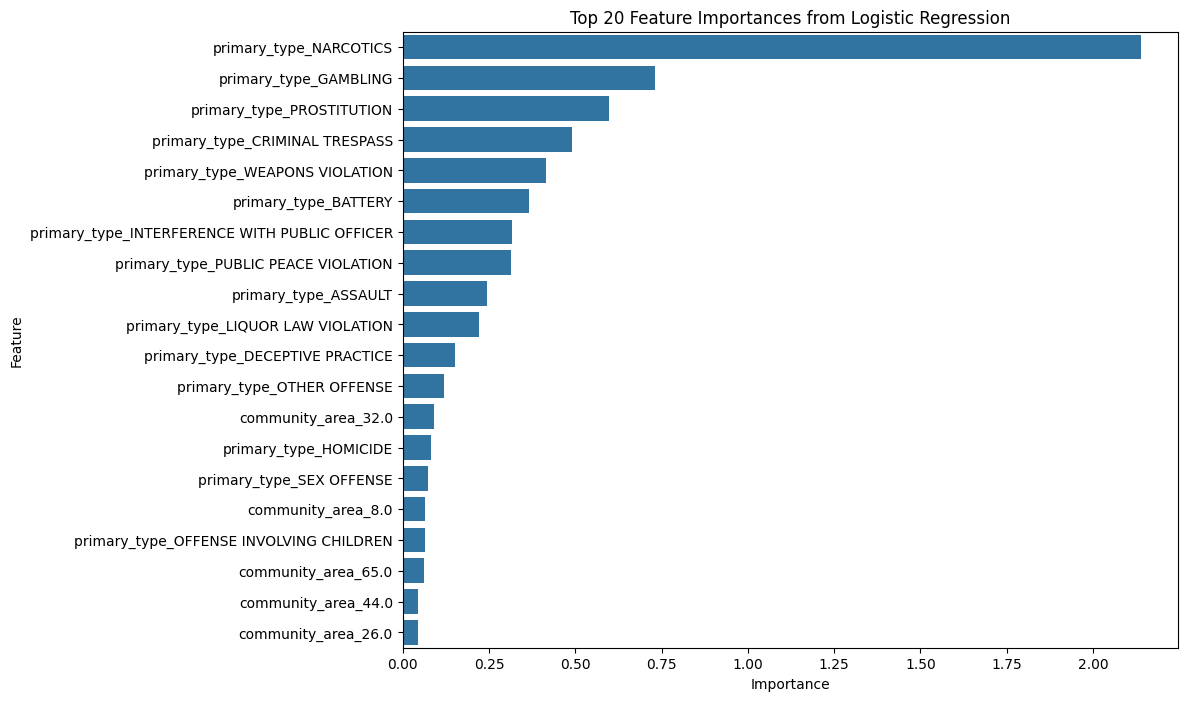

In [29]:
#  logistic regression feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=avg_feat_importances.head(20))
plt.title('Top 20 Feature Importances from Logistic Regression')
plt.show()

---

### **Random Forest**

In [30]:
# the Random Forest model utilises a randomized search to find the best parameters for each dataset
def train_rf(bootstrap_aggregation, var):
    # Each model with utilise a randomized search to find the best parameters
    param_dist = {
        'n_estimators': stats.randint(50, 200),
        'max_depth': [None] + list(range(5, 21)),
        'min_samples_split': stats.randint(2, 15),
        'min_samples_leaf': stats.randint(1, 10)
    }

    # Initialize lists to store cross-validation scores for each metric
    f1_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    rf_models = []
    
    # creating 10 random seed values to be used in the resampling for reproducibility. Same seeds as the previous model.
    random.seed(0)
    random_values = [random.randint(0, 1000) for _ in range(10)] # [864, 394, 776, 911, 430, 41, 265, 988, 523, 497]

    for i, dataset in enumerate(bootstrap_aggregation):
        X_train = dataset[dataset.columns.drop([var])]
        y_train = dataset[var]
        # Initial Random Forest model for hyperparameter tuning
        rf = RandomForestClassifier(random_state=random_values[i], n_jobs=-1)
        
        # Randomized search to find the best parameters for each dataset
        random_search = RandomizedSearchCV(
            estimator=rf, 
            param_distributions=param_dist, 
            n_iter=30,
            scoring='roc_auc',
            cv=5,
            n_jobs=-1,
            random_state=random_values[i],
            verbose=0
        )
        
        random_search.fit(X_train, y_train)
        
        # Get the best parameters and initialize the model with them
        best_params = random_search.best_params_
        print(f'Best Parameters from Randomized Search for {var}:', best_params)
        # appending the best parameters to the model
        model = RandomForestClassifier(**best_params, random_state=random_values[i], n_jobs=-1)
        model.fit(X_train, y_train)
        rf_models.append(model)
        
        # prediction for the training data
        y_pred = model.predict(X_train)
        
        # evaluation metrics
        f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_pred, y_train)
        
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)

    # Calculate mean scores across all models
    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_auc_scores)
    mean_pr_auc = np.mean(pr_auc_scores)
    
    # Print results
    print(f"\nTraining Mean F1 Score across all models: {mean_f1:.4f}")
    print(f"Training Mean ROC AUC across all models: {mean_roc_auc:.4f}")
    print(f"Training Mean Precision-Recall AUC across all models: {mean_pr_auc:.4f}")
    
    return rf_models


In [31]:
def ensemble_rf_predict(rf_models, test_data):
    x_test = test_data[test_data.columns.drop(['arrest'])]
    y_test = test_data['arrest']

    # Gather predictions from each model in the ensemble
    predictions = np.array([rf.predict(x_test) for rf in rf_models])
    # Ge the majority vote for the predictions
    mode_prediction_ = stats.mode(predictions, axis = 0)
    y_pred = mode_prediction_[0]

    # Evaluation metrics
    f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_pred, y_test)
    
    print("\nRandom Forest Classification Model Evaluation:")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    print("Confusion Matrix:")
    print(f"\t{confusion_matrix_[0]}")
    print(f"\t{confusion_matrix_[1]}")
    print("Classification Report:")
    print(f"{classification_report_}")
    
    return rf_models, y_pred, predictions

In [32]:
def get_top_features(rf_models):
    # Get the average feature importances with names from the ensemble of models and sort them.
    avg_feature_importances = np.mean([rf.feature_importances_ for rf in rf_models], axis=0)
    feature_names = crime_data_df_arrest.columns.drop('arrest')
    feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': avg_feature_importances})
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    #print(feature_importances_df)
    
    # graph top 20 features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.show()

In [33]:
arrest_rf = train_rf(arrest_ba, 'arrest')

Best Parameters from Randomized Search for arrest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 120}
Best Parameters from Randomized Search for arrest: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 13, 'n_estimators': 125}


KeyboardInterrupt: 

In [ ]:
rf_models, rf_preds, rf_all_predictions = ensemble_rf_predict(arrest_rf, arrest_test)


Random Forest Classification Model Evaluation:
F1 Score: 0.7036
ROC AUC Score: 0.7852
Precision-Recall AUC: 0.7635
Confusion Matrix:
	[46211  2899]
	[ 6727 11427]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     49110
           1       0.80      0.63      0.70     18154

    accuracy                           0.86     67264
   macro avg       0.84      0.79      0.80     67264
weighted avg       0.85      0.86      0.85     67264



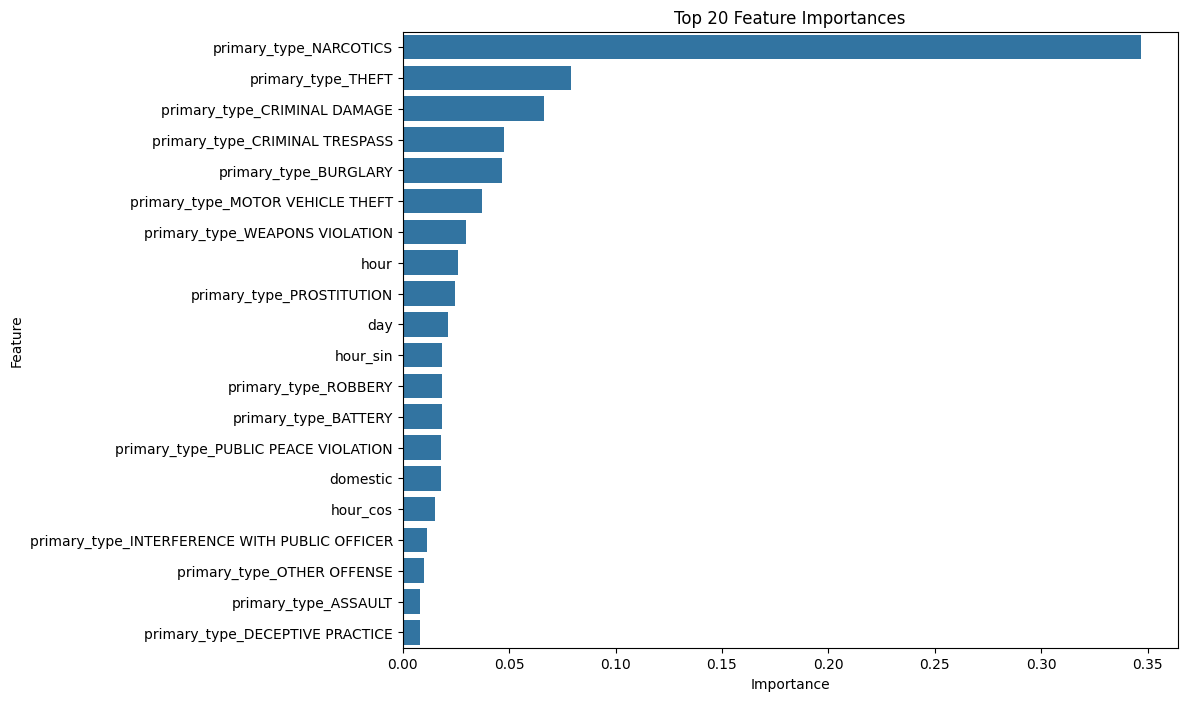

In [ ]:
# graphing the top features from the Random Forest model
get_top_features(arrest_rf)

---

### **High-Density Based Spatial Clustering of Applications with Noise (HDBSCAN) Clustering Model**

In [ ]:
# The model works by creating n clusters from the dataset. Then for each cluster the probability of arrest is calculated.
# The centroid of each cluster and the probability of arrest is returned for each iteration of the model.

def cluster_HDBSCAN(arrest_ba):
    centroid_sets = []
    
    f1_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    
    # iterate through the bootstrapped datasets
    for i, dataset in enumerate(arrest_ba):
        X_train = dataset[dataset.columns.drop('arrest')]
        y_train = dataset['arrest']
        print(f"Processing bootstrapped dataset {i+1}")
        
        # Scale the data
        #scaler = StandardScaler()
        X_train_scaled = scaler.transform(X_train)
        
        # initialise the HDBSCAN clusterer, fit the model and get the labels
        hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=1)
        hdbscan_labels = hdbscan_clusterer.fit_predict(X_train_scaled)

        # get the unique clusters and calculate the centroids
        unique_clusters = np.unique(hdbscan_labels)
        centroids = []
        centroid_probs = []
        
        for cluster in unique_clusters:
            # clusters with label -1 dont belong to any cluster and are considered noise
            if cluster == -1:
                continue
            
            # assign indicies to each value in the cluster
            cluster_indices = np.where(hdbscan_labels == cluster)[0]
            # label the classification for each value in the cluster
            cluster_labels = y_train.iloc[cluster_indices]
            # calculate the probability of arrest for each cluster
            prob_arrest = np.mean(cluster_labels)
            # calculate the centroid of the cluster
            cluster_centroid = X_train_scaled[cluster_indices].mean(axis=0)
            # append the centroid and probability to the list
            centroids.append(cluster_centroid)
            centroid_probs.append(prob_arrest)
        # append each models centroids and probabilities to the list
        centroid_sets.append((np.array(centroids), centroid_probs))
        
        # Generate predictions for training data
        y_pred = []
        for x in X_train_scaled:
            distances = cdist([x], centroids, metric='euclidean')
            nearest_centroid = np.argmin(distances)
            y_pred.append(1 if centroid_probs[nearest_centroid] >= 0.5 else 0)
        
        # Calculate metrics
        f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_pred, y_train)
        
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)

    # Calculate mean scores across all models
    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_auc_scores)
    mean_pr_auc = np.mean(pr_auc_scores)
    
    # Print results
    print(f"\nTraining Mean F1 Score across all models: {mean_f1:.4f}")
    print(f"Training Mean ROC AUC across all models: {mean_roc_auc:.4f}")
    print(f"Training Mean Precision-Recall AUC across all models: {mean_pr_auc:.4f}")
        
    return centroid_sets

In [ ]:
def classify_HDBSCAN(test_data, centroid_sets):
    X_test = test_data[test_data.columns.drop('arrest')]
    y_test = test_data['arrest']
    
    # Scale the data
    X_test_scaled = scaler.transform(X_test)
    arrest_probs_aggregated = []
    all_predictions = []

    # Generate predictions for test data
    for x in X_test_scaled:
        prob_list = []
        
        for centroids, centroid_probs in centroid_sets:
            distances = cdist([x], centroids, metric='euclidean')
            nearest_centroid = np.argmin(distances)
            prob_list.append(centroid_probs[nearest_centroid])
        all_predictions.append(prob_list)
        arrest_probs_aggregated.append(np.mean(prob_list))
        
    y_pred = (np.array(arrest_probs_aggregated) >= 0.5).astype(int)
    
    # Evaluation metrics
    f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_pred, y_test)
    
    print("\nHDBSCAN Classification Model Evaluation:")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    print("Confusion Matrix:")
    print(f"\t{confusion_matrix_[0]}")
    print(f"\t{confusion_matrix_[1]}")
    print("Classification Report:")
    print(f"{classification_report_}")
    
    return y_pred, all_predictions

In [ ]:
centroid_sets = cluster_HDBSCAN(arrest_ba)
cluster_preds, cluster_all_preds = classify_HDBSCAN(arrest_test, centroid_sets)

Processing bootstrapped dataset 1
Processing bootstrapped dataset 2
Processing bootstrapped dataset 3
Processing bootstrapped dataset 4
Processing bootstrapped dataset 5
Processing bootstrapped dataset 6
Processing bootstrapped dataset 7
Processing bootstrapped dataset 8
Processing bootstrapped dataset 9
Processing bootstrapped dataset 10

Training Mean F1 Score across all models: 0.5575
Training Mean ROC AUC across all models: 0.6673
Training Mean Precision-Recall AUC across all models: 0.7709

HDBSCAN Classification Model Evaluation:
F1 Score: 0.4117
ROC AUC Score: 0.6669
Precision-Recall AUC: 0.4470
Confusion Matrix:
	[42322  3864]
	[3691 2644]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     46186
           1       0.41      0.42      0.41      6335

    accuracy                           0.86     52521
   macro avg       0.66      0.67      0.66     52521
weighted avg       0.86      0.86      0.86     5

---

### **Multi-Layer Perceptron**

In [ ]:
# The model is a simple Multi-Layer Perceptron with 3 hidden layers and ReLU activation functions.
# The model uses dropout and weight decay to prevent overfitting.
# Binary cross-entropy loss is used as the loss function and Adam as the optimizer with a learning rate of 0.001.

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # defining the model architecture with 3 hidden layers and dropout
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [ ]:
def train_mlp_model(X_train, y_train, X_val, y_val):
    # Initialize the model
    input_size = X_train.shape[1]
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MLP(input_size).to(device)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Add learning rate and weight decay

    # Move data to GPU
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)

    # Prepare data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Track loss and early stopping criteria
    num_epochs = 200
    epoch_losses = []
    val_losses = []
    # Early stopping criteria
    best_val_loss = float('inf')
    patience = 5
    min_es = 0.001
    patience_counter = 0

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # use batch processing for imporved convergence speed
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        
        avg_train_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss - min_es:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        # printing the loss for each epoch
        #print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    return model, epoch_losses, val_losses

In [ ]:
# graphing the loss for each epoch for all 10 models
def plot_loss_curves(all_epoch_losses, all_val_losses):
    plt.figure(figsize=(12, 8))
    for i, (epoch_losses, val_losses) in enumerate(zip(all_epoch_losses, all_val_losses)):
        plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label=f"Train Loss Model {i+1}")
        plt.plot(range(1, len(val_losses) + 1), val_losses, linestyle="--", label=f"Val Loss Model {i+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs for Each Model")
    plt.legend()
    plt.show()

In [ ]:
def mlp_classifier(downsampled_datasets):
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    models = []
    f1_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    all_epoch_losses = []
    all_val_losses = []

    for i, dataset in enumerate(downsampled_datasets):
        X_train = dataset[dataset.columns.drop('arrest')]
        y_train = dataset['arrest']
        print(f"Processing bootstrapped dataset {i+1}")

        # Split into training and validation sets (e.g., 80/20 split)
        from sklearn.model_selection import train_test_split
        X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=i)

        # Scale and convert data to tensors
        X_train_scaled = scaler.transform(X_train_split)
        X_val_scaled = scaler.transform(X_val)
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_split.values, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

        # Train model with validation
        model, epoch_losses, val_losses = train_mlp_model(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
        # append the model and losses to the list
        models.append(model)
        all_epoch_losses.append(epoch_losses)
        all_val_losses.append(val_losses)

        # Predict for training data
        with torch.no_grad():
            model.eval()
            y_pred = model(X_train_tensor).squeeze().cpu().numpy()
            y_pred = (y_pred >= 0.5).astype(int)

        # Calculate metrics
        f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_pred, y_train_split)

        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)
    
    # Plot loss curves
    plot_loss_curves(all_epoch_losses, all_val_losses)

    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_auc_scores)
    mean_pr_auc = np.mean(pr_auc_scores)

    print(f"\nTraining Mean F1 Score across all models: {mean_f1:.4f}")
    print(f"Training Mean ROC AUC across all models: {mean_roc_auc:.4f}")
    print(f"Training Mean Precision-Recall AUC across all models: {mean_pr_auc:.4f}")

    return models

In [ ]:
def mlp_predict(train_data, test_data):
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    models = mlp_classifier(train_data)
    
    # Scale and convert test data to tensors
    X_test = test_data[test_data.columns.drop('arrest')]
    y_test = test_data['arrest']
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

    all_probs = []
    # Predict for test data on each model
    for model in models:
        model.eval()
        with torch.no_grad():
            probs = model(X_test_tensor).squeeze().cpu().numpy()
            all_probs.append(probs)
    
    # Average probabilities across models
    average_probs = np.mean(all_probs, axis=0)
    # Assign class labels based on the average probabilities where >= 0.5 is 1 and < 0.5 is 0
    y_pred = (average_probs >= 0.5).astype(int)

    # Evaluation metrics
    f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_pred, y_test)
    
    print("\nMLP Classification Model Evaluation:")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    print("Confusion Matrix:")
    print(f"\t{confusion_matrix_[0]}")
    print(f"\t{confusion_matrix_[1]}")
    print("Classification Report:")
    print(f"{classification_report_}")
    
    return models, y_pred


In [ ]:
mlp_models, mlp_predictions = mlp_predict(arrest_ba, arrest_test)

Processing bootstrapped dataset 1
Early stopping triggered after 20 epochs
Processing bootstrapped dataset 2
Early stopping triggered after 23 epochs
Processing bootstrapped dataset 3


KeyboardInterrupt: 

---

## **Final Results**

### **Majority Voting**

In [ ]:
# Stacking the predictions from each model to create a stacked model
model_predictions = [nb_preds, lr_preds, rf_preds, cluster_preds, mlp_predictions]
model_predictions = np.array(model_predictions)
stacked_predictions = np.column_stack(model_predictions)

In [ ]:
def stacked_majority_voting(stacked_predictions):
    # majority voting for the stacked predictions
    return stats.mode(stacked_predictions, axis=0)

In [ ]:
stacked_preds = stacked_majority_voting(model_predictions)[0].flatten()

# Evaluation metrics for the stacked model
f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(arrest_test['arrest'], stacked_preds)
print("Stacked Model Evaluation:")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print("Confusion Matrix:")
print(f"\t{confusion_matrix_[0]}")
print(f"\t{confusion_matrix_[1]}")
print("Classification Report:")
print(f"{classification_report_}")

Stacked Model Evaluation:
F1 Score: 0.4423
ROC AUC: 0.6384
Precision-Recall AUC: 0.5849
Confusion Matrix:
	[37464  2060]
	[8722 4275]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87     39524
           1       0.67      0.33      0.44     12997

    accuracy                           0.79     52521
   macro avg       0.74      0.64      0.66     52521
weighted avg       0.78      0.79      0.77     52521



### **Ensemble MLP**

In [ ]:
# Split stacked_predictions and y_test into train and validation sets
y_test = arrest_test['arrest'].values
X_train, X_val, y_train, y_val = train_test_split(stacked_predictions, y_test, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [ ]:
# very simple MLP to get a non-linear decision boundary

class EnsembleMLP(nn.Module):
    def __init__(self):
        super(EnsembleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 16),  # 5 input features for each models prediction
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [ ]:
def train_ensemble_mlp(X_train, y_train, X_val, y_val):
    # Initialize model, criterion, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EnsembleMLP().to(device)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Move data to GPU if available
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)

    # Training settings
    num_epochs = 100
    batch_size = 32
    # Early stopping criteria
    patience = 5
    min_es = 0.001
    best_val_loss = float('inf')
    patience_counter = 0

    # Prepare data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # use batch processing for imporved convergence speed
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).squeeze()
            val_loss = criterion(val_outputs, y_val).item()
            val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}") 

        # Early stopping check
        if val_loss < best_val_loss - min_es:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return model, train_losses, val_losses


Epoch 1: Train Loss = 0.3401, Val Loss = 0.2889
Epoch 2: Train Loss = 0.2869, Val Loss = 0.2897
Epoch 3: Train Loss = 0.2865, Val Loss = 0.2876
Epoch 4: Train Loss = 0.2861, Val Loss = 0.2876
Epoch 5: Train Loss = 0.2862, Val Loss = 0.2877
Epoch 6: Train Loss = 0.2860, Val Loss = 0.2874
Epoch 7: Train Loss = 0.2858, Val Loss = 0.2877
Epoch 8: Train Loss = 0.2859, Val Loss = 0.2872
Early stopping triggered after 8 epochs


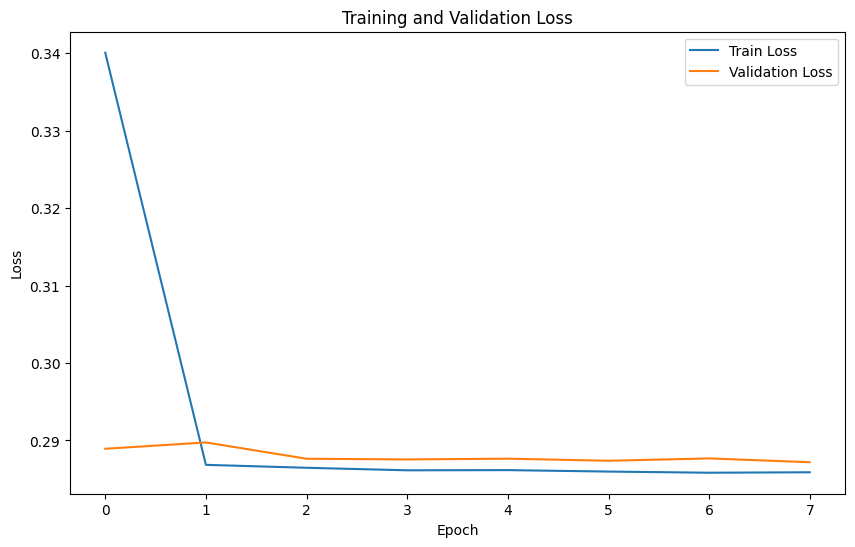

In [ ]:
# Train the ensemble MLP
ensemble_model, train_losses, val_losses = train_ensemble_mlp(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate on validation set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure correct device
ensemble_model.eval()
with torch.no_grad():
    # Move X_val_tensor to the same device as the model
    val_preds = ensemble_model(X_val_tensor.to(device)).squeeze().cpu().numpy()  # Move predictions to CPU
    val_preds = (val_preds >= 0.5).astype(int)  # Convert probabilities to binary predictions

# Ensure y_val is moved to CPU and converted to NumPy
y_val_cpu = y_val_tensor.cpu().numpy()  # Convert ground truth to CPU and NumPy

# Calculate metrics
f1, roc_auc, pr_auc, confusion_matrix_, classification_report_ = eval_metrics(y_val_cpu, val_preds)

# Print metrics
print("Ensemble MLP Validation Metrics:")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print("Confusion Matrix:")
print(f"\t{confusion_matrix_[0]}")
print(f"\t{confusion_matrix_[1]}")
print("Classification Report:")
print(f"{classification_report_}")

Ensemble MLP Validation Metrics:
F1 Score: 0.4608
ROC AUC: 0.7874
Precision-Recall AUC: 0.5182
Confusion Matrix:
	[8975  836]
	[236 458]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      9811
           1       0.35      0.66      0.46       694

    accuracy                           0.90     10505
   macro avg       0.66      0.79      0.70     10505
weighted avg       0.93      0.90      0.91     10505

